In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import seaborn as sns
import numpy as np
import warnings
import pickle
import json
from xgboost import XGBClassifier
warnings.filterwarnings('ignore')

##Data Read, Clean, Analysis

In [45]:
df_ = pd.read_csv('churn_train.csv')
df = df_.copy()
df

year  month  user_account_id  user_lifetime  user_intake  \
0      2013      6           202550           1835            0   
1      2013      6           930164            536            0   
2      2013      6            46907           1046            0   
3      2013      8          1174456          15947            0   
4      2013      6           300131           1630            0   
...     ...    ...              ...            ...          ...   
59995  2013      6          1150129             80            0   
59996  2013      6           950606            326            0   
59997  2013      6          1100429            138            0   
59998  2013      8          1193962          15947            0   
59999  2013      6           390803           1077            0   

       user_no_outgoing_activity_in_days  user_account_balance_last  \
0                                      1                       9.66   
1                                     10                      54.92   
2                                      1                      16.25   
3                                      8                       0.00   
4                                      1                       6.14   
...                                  ...                        ...   
59995                                 24                      11.60   
59996                                  3                       3.75   
59997                                  1                      22.53   
59998                                  8                       0.00   
59999                                  1                       1.38   

       user_spendings  user_has_outgoing_calls  user_has_outgoing_sms  ...  \
0                2.26                        1                      1  ...   
1                0.60                        1                      1  ...   
2               13.47                        1                      1  ...   
3                0.00                        1                      0  ...   
4                3.76                        1                      1  ...   
...               ...                      ...                    ...  ...   
59995            2.53                        1                      0  ...   
59996            4.25                        1                      1  ...   
59997           37.45                        1                      1  ...   
59998            0.00                        0                      0  ...   
59999            6.22                        1                      1  ...   

       last_100_calls_outgoing_duration  \
0                                 45.35   
1                                 24.98   
2                                116.47   
3                                  0.00   
4                                 30.38   
...                                 ...   
59995                             33.43   
59996                             40.35   
59997                            669.35   
59998                              0.00   
59999                            123.08   

       last_100_calls_outgoing_to_onnet_duration  \
0                                            0.0   
1                                            0.0   
2                                           15.2   
3                                            0.0   
4                                            0.0   
...                                          ...   
59995                                        0.0   
59996                                        0.0   
59997                                        0.0   
59998                                        0.0   
59999                                        0.0   

       last_100_calls_outgoing_to_offnet_duration  \
0                                           26.62   
1                                           23.90   
2                                           65.65   
3                                            0.00   
4    

In [6]:
df.isnull().sum()

year                                     0
month                                    0
user_account_id                          0
user_lifetime                            0
user_intake                              0
                                        ..
last_100_sms_outgoing_to_onnet_count     0
last_100_sms_outgoing_to_offnet_count    0
last_100_sms_outgoing_to_abroad_count    0
last_100_gprs_usage                      0
churn                                    0
Length: 66, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 66 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        60000 non-null  int64  
 1   month                                       60000 non-null  int64  
 2   user_account_id                             60000 non-null  int64  
 3   user_lifetime                               60000 non-null  int64  
 4   user_intake                                 60000 non-null  int64  
 5   user_no_outgoing_activity_in_days           60000 non-null  int64  
 6   user_account_balance_last                   60000 non-null  float64
 7   user_spendings                              60000 non-null  float64
 8   user_has_outgoing_calls                     60000 non-null  int64  
 9   user_has_outgoing_sms                       60000 non-null  int64  
 10  user_use_g

In [8]:
df['user_account_id'].nunique() #Tekil mÃ¼ÅŸteri sayÄ±sÄ±

60000

In [9]:
df = df.drop('user_account_id', axis=1)

In [43]:
X = df.drop(columns=["churn"])
y = df["churn"]

##Feature Importance

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

	â€¢	Korelasyon analizi: Hedef deÄŸiÅŸkenle en Ã§ok iliÅŸkili olanlarÄ± bulur.
	â€¢	Mutual Information: Bilgi teorisi bazlÄ± Ã¶nem derecesi belirler.
	â€¢	Random Forest: Model tabanlÄ± Ã¶nem sÄ±ralamasÄ± Ã§Ä±karÄ±r.
	â€¢	RFE: Ã–zellikleri iteratif olarak eleme yÃ¶ntemiyle en iyi olanlarÄ± belirler.

In [20]:
#correlation
corr_matrix = df.corr()

# Churn deÄŸiÅŸkeniyle olan korelasyonlarÄ± sÄ±ralayarak en Ã¶nemli 10 Ã¶zelliÄŸi bul
top_features = corr_matrix[target].abs().sort_values(ascending=False)[1:11]

print("En Ã¶nemli 10 Ã¶zellik (Korelasyon):")
print(top_features)


En Ã¶nemli 10 Ã¶zellik (Korelasyon):
user_has_outgoing_calls                   0.553745
calls_outgoing_inactive_days              0.546338
calls_outgoing_to_abroad_inactive_days    0.546338
calls_outgoing_to_offnet_inactive_days    0.546338
calls_outgoing_to_onnet_inactive_days     0.546338
sms_outgoing_to_abroad_inactive_days      0.539443
sms_outgoing_to_offnet_inactive_days      0.539443
sms_outgoing_to_onnet_inactive_days       0.539443
sms_outgoing_inactive_days                0.539443
user_lifetime                             0.529546
Name: churn, dtype: float64


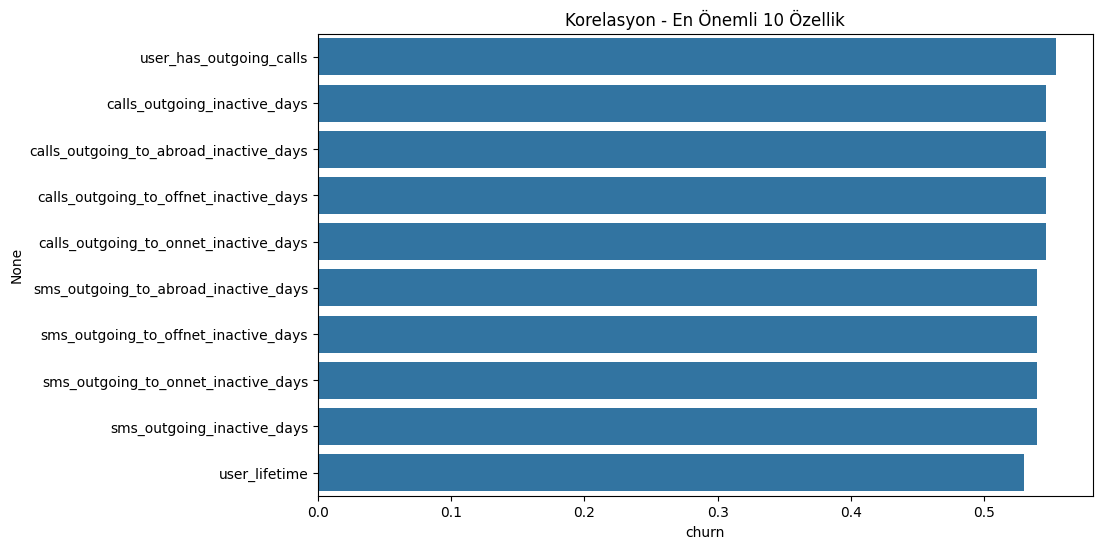

In [26]:
plt.figure(figsize=(10,6))
sns.barplot(x=top_features[:10], y=top_features.index[:10])
plt.title("Korelasyon - En Ã–nemli 10 Ã–zellik")
plt.show()

In [18]:
# Mutual Information
mi_scores = mutual_info_classif(X_train, y_train)

mi_df = pd.DataFrame({"Feature": X.columns, "MI Score": mi_scores})
mi_df = mi_df.sort_values(by="MI Score", ascending=False)

print("En Ã¶nemli 10 Ã¶zellik (Mutual Information):")
print(mi_df.head(10))


En Ã¶nemli 10 Ã¶zellik (Mutual Information):
                                   Feature  MI Score
55        last_100_calls_outgoing_duration  0.176925
44    sms_outgoing_to_abroad_inactive_days  0.171137
35              sms_outgoing_inactive_days  0.170093
38     sms_outgoing_to_onnet_inactive_days  0.169737
41    sms_outgoing_to_offnet_inactive_days  0.168097
14                    calls_outgoing_count  0.167932
6                           user_spendings  0.167850
19            calls_outgoing_inactive_days  0.167628
31  calls_outgoing_to_abroad_inactive_days  0.167329
23   calls_outgoing_to_onnet_inactive_days  0.165512


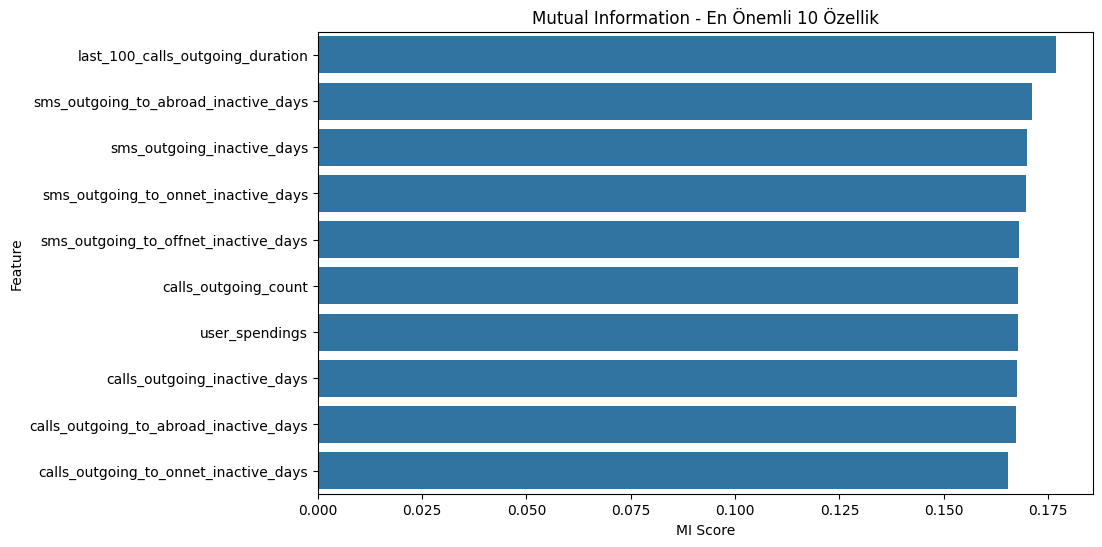

In [19]:
plt.figure(figsize=(10,6))
sns.barplot(x=mi_df["MI Score"][:10], y=mi_df["Feature"][:10])
plt.title("Mutual Information - En Ã–nemli 10 Ã–zellik")
plt.show()

En Ã¶nemli 10 Ã¶zellik (Random Forest):
                                       Feature  Importance
55            last_100_calls_outgoing_duration    0.118303
2                                user_lifetime    0.073089
45                          sms_incoming_count    0.069374
6                               user_spendings    0.064277
14                        calls_outgoing_count    0.054657
16                     calls_outgoing_duration    0.046192
57  last_100_calls_outgoing_to_offnet_duration    0.040845
5                    user_account_balance_last    0.040190
27      calls_outgoing_to_offnet_inactive_days    0.038033
18                 calls_outgoing_duration_max    0.037356


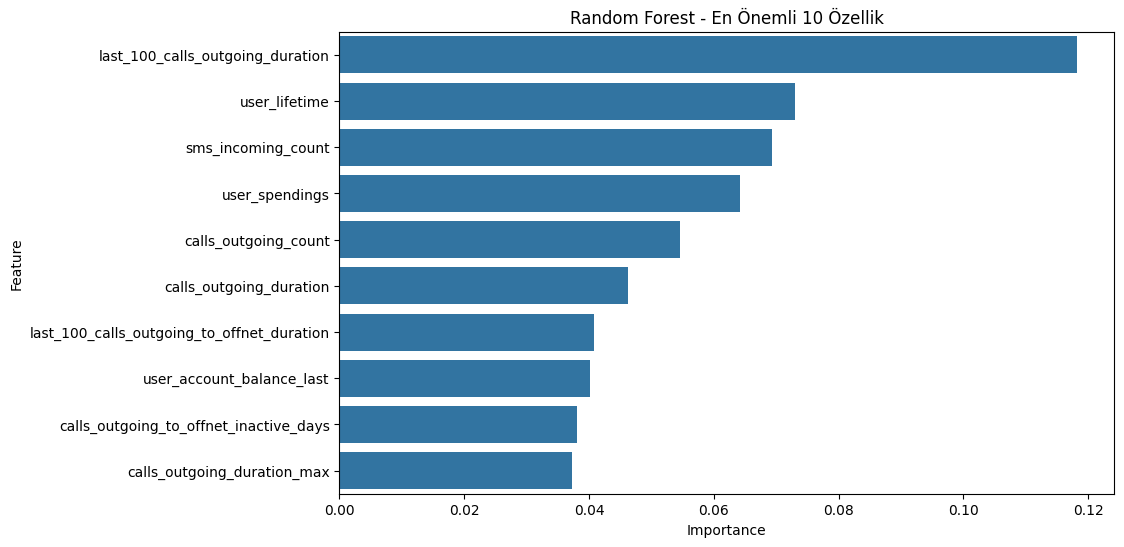

In [14]:
#Random Forest ile Feature Importance

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

feature_importances = pd.DataFrame({"Feature": X.columns, "Importance": rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

print("En Ã¶nemli 10 Ã¶zellik (Random Forest):")
print(feature_importances.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances["Importance"][:10], y=feature_importances["Feature"][:10])
plt.title("Random Forest - En Ã–nemli 10 Ã–zellik")
plt.show()

In [15]:
#Recursive Feature Elimination (RFE)

log_model = LogisticRegression(max_iter=1000, solver="liblinear")

rfe = RFE(log_model, n_features_to_select=10)
rfe.fit(X_train, y_train)

rfe_features = X_train.columns[rfe.support_]

print("En Ã¶nemli 10 Ã¶zellik (RFE):")
print(rfe_features)

En Ã¶nemli 10 Ã¶zellik (RFE):
Index(['month', 'user_intake', 'user_has_outgoing_calls',
       'user_has_outgoing_sms', 'user_does_reload',
       'calls_outgoing_spendings_max', 'calls_outgoing_duration_max',
       'calls_outgoing_to_offnet_spendings', 'sms_outgoing_spendings_max',
       'sms_outgoing_to_onnet_spendings'],
      dtype='object')


ðŸ”¹ %95 varyans iÃ§in optimum bileÅŸen sayÄ±sÄ±: 32
ðŸ”¹ %99 varyans iÃ§in optimum bileÅŸen sayÄ±sÄ±: 45


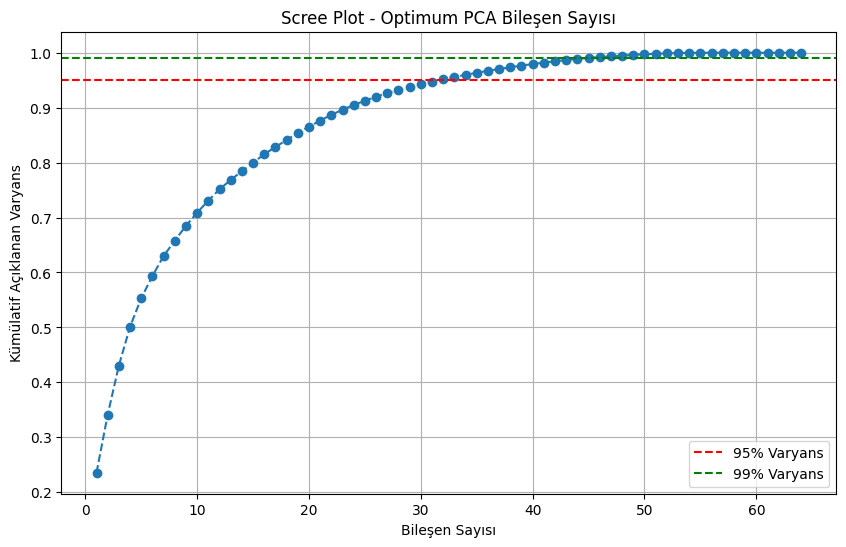

In [27]:
# Veriyi Ã¶lÃ§eklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

explained_variance = np.cumsum(pca.explained_variance_ratio_)

optimum_components_95 = np.argmax(explained_variance >= 0.95) + 1
optimum_components_99 = np.argmax(explained_variance >= 0.99) + 1

print(f"ðŸ”¹ %95 varyans iÃ§in optimum bileÅŸen sayÄ±sÄ±: {optimum_components_95}")
print(f"ðŸ”¹ %99 varyans iÃ§in optimum bileÅŸen sayÄ±sÄ±: {optimum_components_99}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker="o", linestyle="--")
plt.axhline(y=0.95, color="r", linestyle="--", label="95% Varyans")
plt.axhline(y=0.99, color="g", linestyle="--", label="99% Varyans")
plt.xlabel("BileÅŸen SayÄ±sÄ±")
plt.ylabel("KÃ¼mÃ¼latif AÃ§Ä±klanan Varyans")
plt.title("Scree Plot - Optimum PCA BileÅŸen SayÄ±sÄ±")
plt.legend()
plt.grid()
plt.show()

In [28]:
# PCA modeli oluÅŸturma ve eÄŸitme
n = 10
pca = PCA(n_components=n)
X_pca = pca.fit_transform(X_scaled)

# BileÅŸenlerin aÃ§Ä±klanan varyans yÃ¼zdelerini gÃ¶sterme
explained_variance = pca.explained_variance_ratio_
print(f"AÃ§Ä±klanan Varyans OranlarÄ± {n} BileÅŸen:")
print(explained_variance)

# BileÅŸenlerin hangi Ã¶zelliklerle daha fazla iliÅŸkili olduÄŸunu gÃ¶sterme
pca_components = pd.DataFrame(pca.components_, columns=X.columns, index=[f"PC{i+1}" for i in range(n)])

# En bÃ¼yÃ¼k mutlak katsayÄ± deÄŸerine gÃ¶re en Ã§ok etkileyen Ã¶zellikleri seÃ§me
top_features_pca = []
for i in range(n):
    top_feature = pca_components.iloc[i].abs().idxmax()
    top_features_pca.append(top_feature)

print(f"PCA ile en Ã¶nemli {n} Ã¶zellik:")
print(top_features_pca)

AÃ§Ä±klanan Varyans OranlarÄ± 10 BileÅŸen:
[0.23549736 0.1055835  0.08945844 0.0707148  0.05193501 0.04046211
 0.03625029 0.0280965  0.02691515 0.02398714]
PCA ile en Ã¶nemli 10 Ã¶zellik:
['user_spendings', 'calls_outgoing_inactive_days', 'calls_outgoing_to_onnet_duration', 'sms_outgoing_to_offnet_count', 'gprs_session_count', 'sms_outgoing_to_onnet_count', 'reloads_inactive_days', 'sms_outgoing_to_abroad_spendings', 'sms_outgoing_to_abroad_spendings', 'user_account_balance_last']


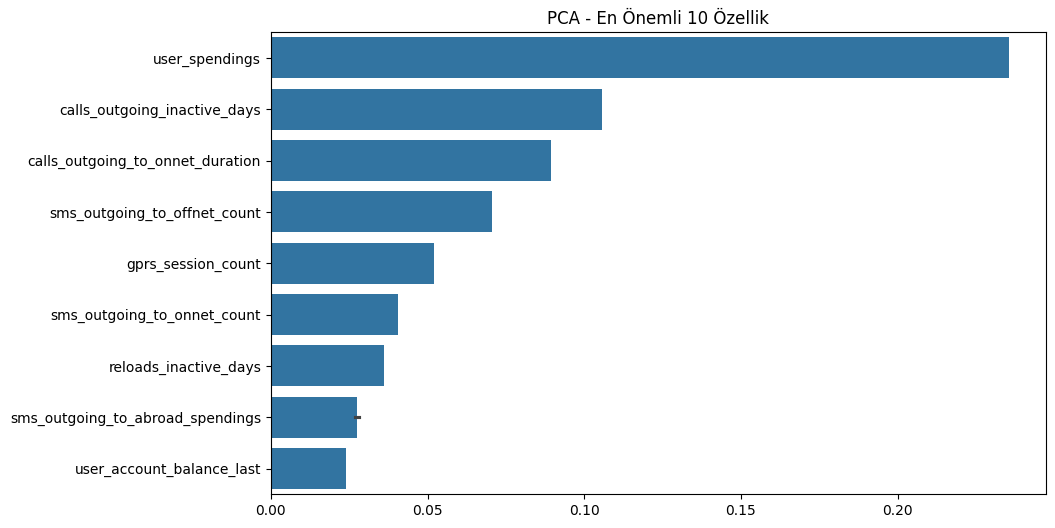

In [30]:
plt.figure(figsize=(10,6))
sns.barplot(x=explained_variance, y=top_features_pca)
plt.title("PCA - En Ã–nemli 10 Ã–zellik")
plt.show()

In [42]:
top_features_pca.extend(rfe_features)
top_features_pca.extend(feature_importances["Feature"][:10])
top_features_pca.extend(mi_df["Feature"][:10])
top_features_pca.extend(top_features.index[:10])

important_features = list(set(top_features_pca))
with open("features.json", "w", encoding="utf-8") as json_file:
    json.dump({"features": important_features}, json_file, ensure_ascii=False, indent=4)
important_features

['sms_outgoing_spendings_max',
 'sms_outgoing_to_onnet_spendings',
 'calls_outgoing_spendings_max',
 'calls_outgoing_to_offnet_inactive_days',
 'sms_outgoing_to_abroad_inactive_days',
 'last_100_calls_outgoing_to_offnet_duration',
 'calls_outgoing_to_onnet_duration',
 'user_spendings',
 'sms_outgoing_to_offnet_inactive_days',
 'sms_outgoing_to_onnet_count',
 'user_lifetime',
 'reloads_inactive_days',
 'calls_outgoing_to_offnet_spendings',
 'sms_incoming_count',
 'gprs_session_count',
 'calls_outgoing_duration_max',
 'sms_outgoing_to_abroad_spendings',
 'user_intake',
 'calls_outgoing_to_abroad_inactive_days',
 'sms_outgoing_to_onnet_inactive_days',
 'calls_outgoing_duration',
 'user_has_outgoing_sms',
 'user_has_outgoing_calls',
 'sms_outgoing_to_offnet_count',
 'user_account_balance_last',
 'sms_outgoing_inactive_days',
 'calls_outgoing_to_onnet_inactive_days',
 'calls_outgoing_inactive_days',
 'user_does_reload',
 'calls_outgoing_count',
 'last_100_calls_outgoing_duration',
 'month']

##Model Development

In [48]:
df[important_features].values

array([[6.0000e-02, 0.0000e+00, 3.3000e-01, ..., 4.0000e+01, 4.5350e+01,
        6.0000e+00],
       [6.0000e-02, 0.0000e+00, 0.0000e+00, ..., 2.0000e+00, 2.4980e+01,
        6.0000e+00],
       [1.1000e-01, 0.0000e+00, 3.0100e+00, ..., 4.5000e+01, 1.1647e+02,
        6.0000e+00],
       ...,
       [1.5000e+00, 0.0000e+00, 1.5700e+00, ..., 1.7500e+02, 6.6935e+02,
        6.0000e+00],
       [0.0000e+00, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        8.0000e+00],
       [6.0000e-02, 6.0000e-02, 5.7000e-01, ..., 2.0100e+02, 1.2308e+02,
        6.0000e+00]])

In [49]:
X = df[important_features].values
y = df["churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelleri oluÅŸtur
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

# Modelleri eÄŸit ve test et
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # AUC iÃ§in olasÄ±lÄ±klar

    # Performans Metrikleri
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    print(f"ðŸ”¹ {name} - Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))
    pickle.dump(model, open(name + '.pkl', 'wb'))

ðŸ”¹ Logistic Regression - Accuracy: 0.8681, AUC: 0.8836
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      9477
           1       0.73      0.60      0.66      2523

    accuracy                           0.87     12000
   macro avg       0.81      0.77      0.79     12000
weighted avg       0.86      0.87      0.86     12000

ðŸ”¹ Random Forest - Accuracy: 0.8738, AUC: 0.9035
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      9477
           1       0.73      0.64      0.68      2523

    accuracy                           0.87     12000
   macro avg       0.82      0.79      0.80     12000
weighted avg       0.87      0.87      0.87     12000

ðŸ”¹ XGBoost - Accuracy: 0.8758, AUC: 0.9075
              precision    recall  f1-score   support

           0       0.92      0.93      0.92      9477
           1       0.71      0.68      0.70      2523

    accuracy                 